In [9]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib

from ATARI.sammy_interface import sammy_classes, sammy_functions

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from copy import copy

import ATARI.utils.plotting as myplot


In [10]:
%matplotlib widget

In [11]:
sammypath = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy'

# Overview

The synthetic data methodology build here is modeled after measurement data from the work of Jesse Brown at RPI (currently at ORNL).
These measurements are detailed in https://www.tandfonline.com/doi/full/10.1080/00295639.2023.2249786 and consist of 6 experimental configurations.
Of the 4 transmission measurements only 3 are used for evaluation and the 4th (45m FP) is used for validation. 
Both 2 capture measurements are used for evaluation.

The evaluation transmission data are reliable in the range 0.15-100 keV.
The capture data are reliable from 0.15-200 keV. 
The validation transmission data are reliable in the range 0.003-100 keV.

The data that are available are *reduced* data, generally in EXFOR. 
This is what is imported for the evaluation datasets.
Reduced data can be modelled with SAMMY, which models the particle-pair reaction and the experimental conditions.
In ATARI, this is referred to as the theoretical and experimental models.

Ultimately, for the synthetic data methodology, we will need information about the data reduction process.
This information is referred to in ATARI as the measurement model.
Ideally, this information comes from the experimentalist and you have access to all of the parameters used in the reduction process. 
The synthetic data methodology was developed alongside Jesse Brown, therefore, this is the scenario for the 12mm/45mFP validations measurements.
However, this ideal scenario is not always possible and is not the case for the 5 evaluation measurements.

This notebook does the following:
1. Generates synthetic data for the validation case and does a detailed comparison to the real measurement data made possible by full access to the data reduction process.
2. Generates synthetic data for the evaluation cases by making some approximations and assumptions about the reduction process.
3. Does a less-detailed comparison of the synthetic evaluation data to the reduced evaluation measurement data.


# 1. Validation Case

To reiterate, the synthetic data methodology for the 12mm validation measurement is fully informed. 
It has access to the exact reduction parameters (including background and open neutron spectrum) and the raw data itself.
This allows for higher-utility synthetic data and more rigorous statistical comparisons to the real data. 
A journal article detailing this case is can be found at https://doi.org/10.1016/j.cpc.2023.108927.

In [12]:
### import reduced data
transdat12 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-12mm.dat"))
# transdat12_covfile = Need to generate from sys and stat covariances
exptrans12 = Experimental_Model(title = "trans12",
                                reaction = "transmission",
                                energy_range = (3,2500),
                                energy_grid = np.sort(transdat12.E.values),
                                template = os.path.realpath("./data/template_trans12_edited"),
                                sammy_inputs = {
                                    'alphanumeric'       :   ["BROADENING IS WANTED"],
                                    'ResFunc'            :   "ORRES"
                                        },

                                n = (0.067166, 0.0),  
                                FP = (35.185,0.0), 
                                burst = (8,0.0), 
                                temp = (294.2610, 0.0),

                                channel_widths={
                                        "maxE": [26.23   , 110.79  , 2014.67 , 30889.79], 
                                        "chw": [409.6, 204.8,  25.6,  25.6],
                                        "dchw": [0.8]
                                        },

                                additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
                               )

transdat12 = transdat12[(transdat12.E<max(exptrans12.energy_range)) & (transdat12.E>min(exptrans12.energy_range))]

### import raw data
# trans12_explicit_covariance = np.load(os.path.realpath("./data/JB_cov.npy"))
jb_raw_data = pd.read_csv(os.path.realpath("./data/JB_reduction_data.csv"), index_col='Unnamed: 0')
jb_raw_data = jb_raw_data[(jb_raw_data.e<max(exptrans12.energy_range)) & (jb_raw_data.e>min(exptrans12.energy_range))]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/noahwalton/Documents/GitHub/ATARI/examples/Ta181_Analysis/data/JB_reduction_data.csv'

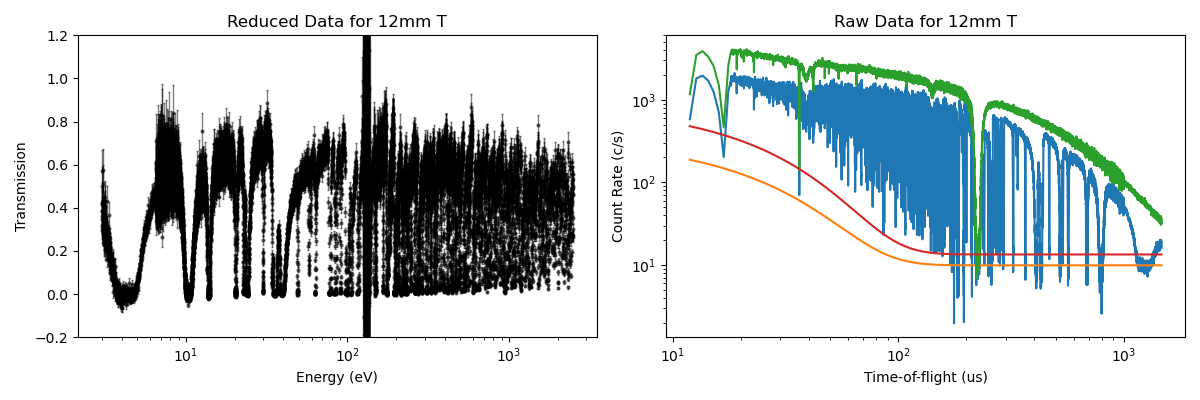

In [ ]:
importlib.reload(myplot)

# plot transmission
fig, axes = subplots(1,2, figsize=(12,4))

axes[0].errorbar(transdat12.E, transdat12.exp, yerr= transdat12.exp_unc,
                  fmt='.', alpha=0.5, color='k', linewidth=1.0, markersize=4, capsize=1, label=exptrans12.title)
axes[0].set_xscale('log')
# axes[0].set_yscale('log')
axes[0].set_ylim([-0.2, 1.2])
axes[0].set_xlabel("Energy (eV)")
axes[0].set_title("Reduced Data for 12mm T")
axes[0].set_ylabel("Transmission")



axes[1].plot(jb_raw_data.tof, jb_raw_data.cs)
axes[1].plot(jb_raw_data.tof, jb_raw_data.bs)

axes[1].plot(jb_raw_data.tof, jb_raw_data.co)
axes[1].plot(jb_raw_data.tof, jb_raw_data.bo)

axes[1].set_xscale('log')
axes[1].set_yscale('log')

axes[1].set_xlabel("Time-of-flight (us)")
axes[1].set_ylabel("Count Rate (c/s)")
axes[1].set_title("Raw Data for 12mm T")


# axes[2].imshow(trans12_explicit_covariance)
# imshow(trans12_explicit_covariance, vmin=-.1, vmax=.1)

# axes[2].colorbar()


fig.tight_layout()

### Approximate the resonances that generated this data

Synthetic data can be generated around any point-wise vector (of the experimental object transmission or capture yield) that is taken as 'true'.
In order to better compare synthetic data to real data, we must approximate the resonance structures that generated the real data and use those as 'true'
For this, you can take the evaluated JEFF parameters or fit the new data from those parameters.


In [ ]:
rto = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True
                              })

matnum = 7328
jeff_file = os.path.realpath("./data/73-Ta-181g.jeff33")
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, rto)

energy_range_all = (4, 2500)
jeff_parameters = jeff_parameters[(jeff_parameters.E<max(exptrans12.energy_range)) & (jeff_parameters.E>min(exptrans12.energy_range))]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*0
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))


### setup the reaction model - Ta-181 is the default
Ta_pair = Particle_Pair()      

sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    jeff_parameters,
    os.path.realpath("./data/template_trans12_edited"),
    exptrans12,
    experimental_data=transdat12,
    # experimental_covariance = datasample.covariance_data
    initial_parameter_uncertainty=1
)

sammyOUT = sammy_functions.run_sammy(sammyINP, rto)
print(sammyOUT.chi2)
print(sammyOUT.chi2_post)

None
43107.4


Text(0, 0.5, 'Transmission')

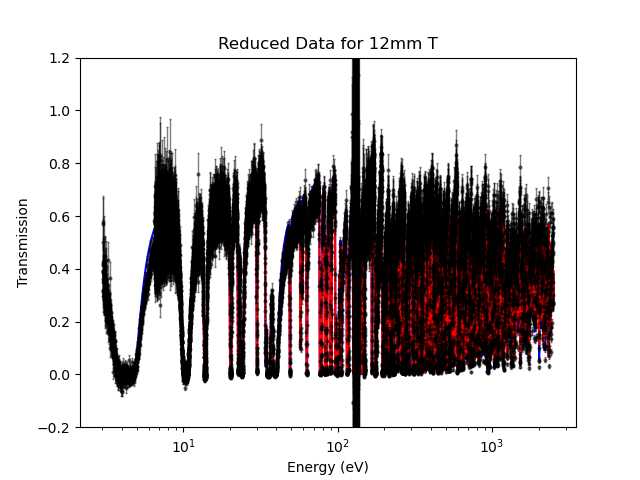

In [ ]:

# plot transmission
figure()

errorbar(transdat12.E, transdat12.exp, yerr= transdat12.exp_unc, #zorder=0,
                  fmt='.', alpha=0.5, color='k', linewidth=1.0, markersize=4, capsize=1, label=exptrans12.title)

plot(sammyOUT.pw_post.E, sammyOUT.pw.theo_trans, color='b', zorder=1)
plot(sammyOUT.pw_post.E, sammyOUT.pw_post.theo_trans_bayes, color='r', zorder=1)

xscale('log')
# axes[0].set_yscale('log')
ylim([-0.2, 1.2])
xlabel("Energy (eV)")
title("Reduced Data for 12mm T")
ylabel("Transmission")


### Build a corresponding Syndat model

Syndat needs both a generative and reductive measurement model. 
The generative model is considered 'true' and is used to generate statistical samples of raw data such as count rates or background functions. 
The raw data are then put through the data reduction model to get to the reduced transmission. 
For now, we can assume that the generative and reductive models are the same.

The parameters used by Jesse Brown in the taking of this data are those given as defaults for the Transmission_RPI measurement model.
The only non-default parameter is the open spectrum. 
Syndat, by default, approximates this with an exponential function. 
If the user has access to the actual open spectrum, then it is preferred to supply it.



In [ ]:
from ATARI.syndat import syndat_model
importlib.reload(syndat_model)
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT

### define measurement models
open_df = copy(jb_raw_data[["e", "tof", "cto", "dcto"]])
open_df.rename(columns={"e":"E", "cto":"ct", "dcto":"dct"}, inplace=True)
open_df['tof'] = open_df['tof']*1e3
open_df['bw'] = abs(np.append(np.diff(open_df['tof']), np.diff(open_df['tof'])[-1])*1e-9)

trans12mm_gen_meas = Transmission_RPI(open_neutron_spectrum = open_df)
trans12mm_red_meas = Transmission_RPI(open_neutron_spectrum = open_df)

### define syndat options and model, do not sample resonances
synOPT = syndatOPT(sampleRES=False, calculate_covariance=True, explicit_covariance=True, save_raw_data=True)

syndat_trans12mm = syndat_model.Syndat_Model(exptrans12,
                            trans12mm_gen_meas,
                            trans12mm_red_meas,
                            options = synOPT,
                            title='trans12mm')

### set the resonance ladder for the reaction model and draw samples
Ta_pair.resonance_ladder = copy(sammyOUT.par_post)
rto.bayes = False
syndat_trans12mm.sample(particle_pair=Ta_pair, 
                    sammyRTO=rto,
                    num_samples=1)

ValueError: neutron spectrum and sample data are not of the same length, check energy domain

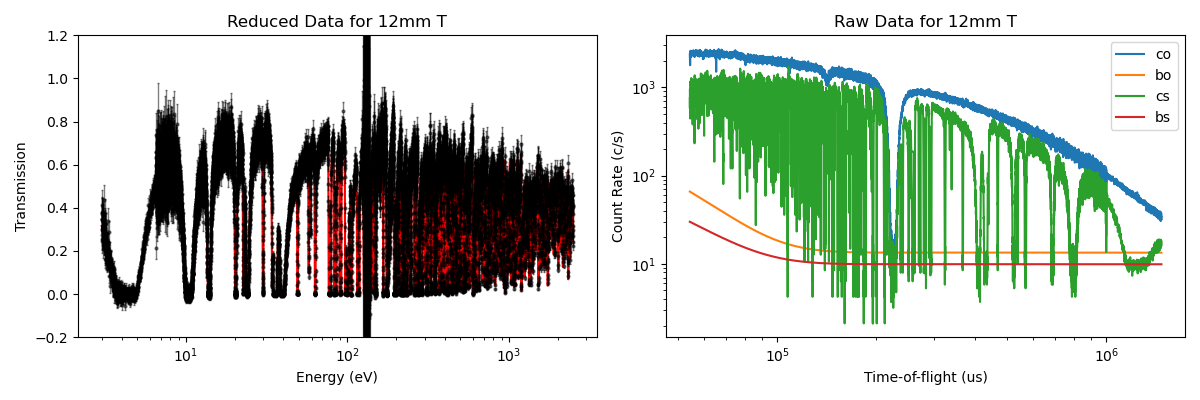

In [ ]:
red_data = syndat_trans12mm.samples[0].pw_reduced
raw_data = syndat_trans12mm.samples[0].pw_raw

# plot transmission
fig, axes = subplots(1,2, figsize=(12,4))

axes[0].errorbar(red_data.E, red_data.exp, yerr=red_data.exp_unc,
                  fmt='.', alpha=0.5, color='k', linewidth=1.0, markersize=4, capsize=1, label=exptrans12.title)
axes[0].plot(red_data.E, red_data.true, color='r', zorder=1)

axes[0].set_xscale('log')
# axes[0].set_yscale('log')
axes[0].set_ylim([-0.2, 1.2])
axes[0].set_xlabel("Energy (eV)")
axes[0].set_title("Reduced Data for 12mm T")
axes[0].set_ylabel("Transmission")


axes[1].plot(raw_data.tof, raw_data.co, label='co')
axes[1].plot(raw_data.tof, raw_data.bo, label='bo')

axes[1].plot(raw_data.tof, raw_data.cs, label='cs')
axes[1].plot(raw_data.tof, raw_data.bs, label='bs')

axes[1].set_xscale('log')
axes[1].set_yscale('log')

axes[1].set_xlabel("Time-of-flight (us)")
axes[1].set_ylabel("Count Rate (c/s)")
axes[1].set_title("Raw Data for 12mm T")


# axes[2].imshow(trans12_explicit_covariance)
# imshow(trans12_explicit_covariance, vmin=-.1, vmax=.1)

# axes[2].colorbar()
axes[1].legend()

fig.tight_layout()

### Comparing how the data is distributed

For the 12mm transmission data, full access to the reduction model and experimentalist that produced the data allows for the highest utility synthetic data.
A full statistical comparison is done in an associated journal publication: (https://www.sciencedirect.com/science/article/pii/S0010465523002722)
Here, we do just a simplified investigation of the distributions structure.
Remember, the synthetic data distribution is an ensemble and the real data is just a single realization.

The following distributions are constructed after filtering the data to areas of the RRR that are well-represented by the fit (150< eV < 850).


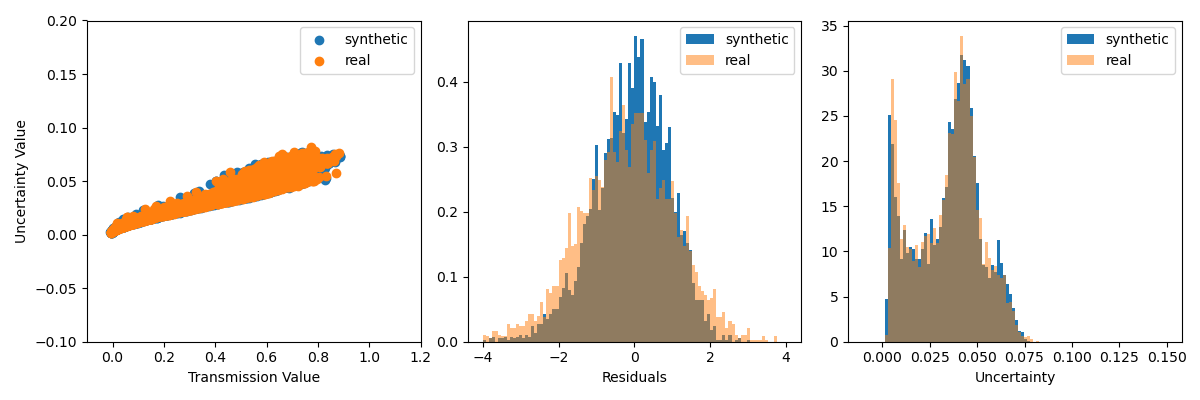

In [ ]:
mask = (red_data.E>150.0) & (red_data.E<850)
synthetic_data = red_data[mask]
real_data = transdat12[mask]


fig, axes = subplots(1,3, figsize=(12,4))

axes[0].scatter(synthetic_data.exp, synthetic_data.exp_unc, label='synthetic')
axes[0].scatter(real_data.exp, real_data.exp_unc, label='real')
axes[0].set_xlim([-0.1,1.2])
axes[0].set_ylim([-0.1, 0.2])
axes[0].set_ylabel("Uncertainty Value")
axes[0].set_xlabel("Transmission Value")

bins = 100
range = (-4,4)
_ = axes[1].hist((synthetic_data.exp-synthetic_data.true)/synthetic_data.exp_unc, bins=bins, range=range, density=True,label='synthetic') #-red_data.true
_ = axes[1].hist((real_data.exp-synthetic_data.true)/real_data.exp_unc, bins=bins, range=range, alpha=0.5,density=True, label='real')#-red_data.true
axes[1].set_xlabel("Residuals")
# range = (-0.1, 1.2)
# _ = axes[1].hist((synthetic_data.exp), bins=bins, range=range, density=True,label='synthetic')  #-red_data.true
# _ = axes[1].hist((real_data.exp), bins=bins, range=range, alpha=0.5,density=True, label='real') #-red_data.true
# axes[1].set_xlabel("Experimental Values")

bins = 100
range = (-.01,.15)
_ = axes[2].hist(synthetic_data.exp_unc, bins=bins, range=range, density=True,label='synthetic')
_ = axes[2].hist(real_data.exp_unc, bins=bins, range=range, alpha=0.5, density=True,label='real')
axes[2].set_xlabel("Uncertainty")

for ax in axes:
    ax.legend()
    
fig.tight_layout()